In [1]:
cd /om2/user/leokoz8/code/rnns-of-rnns

/rdma/vast-rdma/vast/fiete/leokoz8/code/rnns-of-rnns


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import tqdm
from src import models, utils,parametrizations
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau

from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
from neurogym.wrappers.block import MultiEnvs
from neurogym import Dataset
from Mod_Cog.mod_cog_tasks import *

envs = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),
        dm1(), dm2(), ctxdm1(), ctxdm2(), multidm(), dlydm1(), dlydm2(),
        ctxdlydm1(), ctxdlydm2(), multidlydm(), dms(), dnms(), dmc(), dnmc(),
        dlygointr(),dlygointl(),dlyantiintr(),dlyantiintl(),dlydm1intr(),dlydm1intl(),
        dlydm2intr(),dlydm2intl(),ctxdlydm1intr(),ctxdlydm1intl(),ctxdlydm2intr(),ctxdlydm2intl(),
        multidlydmintr(),multidlydmintl(),dmsintr(),dmsintl(),dnmsintr(),
        dnmsintl(),dmcintr(),dmcintl(),dnmcintr(),dnmcintl(), goseqr(), rtgoseqr(), dlygoseqr(), 
        antiseqr(), rtantiseqr(), dlyantiseqr(), dm1seqr(), dm2seqr(), ctxdm1seqr(), ctxdm2seqr(), 
        multidmseqr(), dlydm1seqr(),dlydm2seqr(),ctxdlydm1seqr(), ctxdlydm2seqr(), multidlydmseqr(),
        dmsseqr(), dnmsseqr(), dmcseqr(), dnmcseqr(), goseql(), rtgoseql(), dlygoseql(), antiseql(),
        rtantiseql(), dlyantiseql(), dm1seql(), dm2seql(), ctxdm1seql(), ctxdm2seql(), multidmseql(), dlydm1seql(),
        dlydm2seql(),ctxdlydm1seql(), ctxdlydm2seql(), multidlydmseql(), dmsseql(), dnmsseql(), dmcseql(), dnmcseql()]

envs_names = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti','dm1', 'dm2', 'ctxdm1', 'ctxdm2', 'multidm', 'dlydm1', 'dlydm2',
        'ctxdlydm1', 'ctxdlydm2', 'multidlydm', 'dms', 'dnms', 'dmc', 'dnmc',
        'dlygointr','dlygointl','dlyantiintr','dlyantiintl','dlydm1intr','dlydm1intl',
        'dlydm2intr','dlydm2intl','ctxdlydm1intr','ctxdlydm1intl','ctxdlydm2intr','ctxdlydm2intl',
        'multidlydmintr','multidlydmintl','dmsintr','dmsintl','dnmsintr',
        'dnmsintl','dmcintr','dmcintl','dnmcintr','dnmcintl', 'goseqr', 'rtgoseqr', 'dlygoseqr', 
        'antiseqr', 'rtantiseqr', 'dlyantiseqr', 'dm1seqr', 'dm2seqr', 'ctxdm1seqr', 'ctxdm2seqr', 
        'multidmseqr', 'dlydm1seqr','dlydm2seqr','ctxdlydm1seqr', 'ctxdlydm2seqr', 'multidlydmseqr',
        'dmsseqr', 'dnmsseqr', 'dmcseqr', 'dnmcseqr', 'goseql', 'rtgoseql', 'dlygoseql', 'antiseql',
        'rtantiseql', 'dlyantiseql', 'dm1seql', 'dm2seql', 'ctxdm1seql', 'ctxdm2seql', 'multidmseql', 'dlydm1seql',
        'dlydm2seql','ctxdlydm1seql', 'ctxdlydm2seql', 'multidlydmseql', 'dmsseql', 'dnmsseql', 'dmcseql', 'dnmcseql']

extra_tasks = {'envs': envs, 'envs_names': envs_names}





%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:

def train(net, env,criterion, optimizer, scheduler, training_params):
    
    running_loss = 0.0
    
    num_gradient_steps = training_params['num_gradient_steps']
    eval_every = training_params['eval_every']
    
    act_size = env.action_space.n
    

    pbar = tqdm.trange(num_gradient_steps)
    count_eval = 0
    perf_over_training = torch.zeros(int(num_gradient_steps/eval_every) + 1)

    for i in pbar:
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float).to(device)

        labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs,rnn_outputs = net(inputs)

        loss = criterion(outputs.reshape(-1, act_size), labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % eval_every == eval_every - 1 or i == 0:          
          

            with torch.no_grad():        
                perf = utils.get_performance(net,env,device)
                perf_over_training[count_eval] = perf
                pbar.set_description(f'Performance is {perf} at gradient step {i} with running training loss {running_loss:.2f}')
            count_eval += 1
            
            running_loss = 0.0

            #break if performance above 90
            if perf >= 0.90:
                break
            scheduler.step(perf)



    #pbar.set_description(f'Performance is {perf} at gradient step {i}')
    
    return net,perf_over_training

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"


dataset = Dataset(multidlydmseql(), batch_size=64, seq_len=100)
env = dataset.env


#tasks_and_constraints = [('ctxdm2','sym'),('anti','spectral'),('dlydm2intl','spectral'),('rtgoseqr','sym')]
tasks_and_constraints  = [(envs_names[i],'sym') for i in range(0,19)]
    
net = utils.build_GWNET_from_pretrained(tasks_and_constraints, env, device, gw_hidden_size = 16)

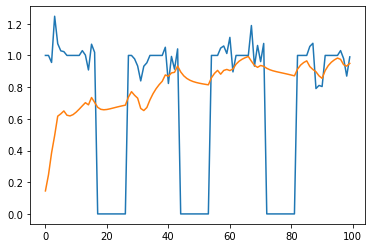

In [71]:
inputs, labels = dataset()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)

labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

with torch.no_grad():
    # forward + backward + optimize
    outputs,rnn_outputs = net(inputs)
    plt.plot(inputs[:,1,0].detach().cpu())
    plt.plot(rnn_outputs[:,1,0].detach().cpu())

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode = 'max',, factor = 0.1)

num_gradient_steps = 5000
eval_every = 100

training_params = {"num_gradient_steps": num_gradient_steps, "eval_every": eval_every}


net_trained, perf_over_training = train(net,env,criterion,optimizer, scheduler,training_params)



Performance is 0.9 at gradient step 3099 with running training loss 15.05:  62%|██████▏   | 3099/5000 [14:36<08:57,  3.53it/s]    


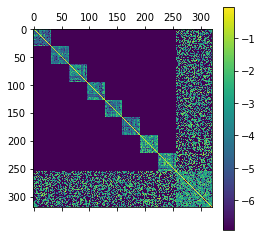

In [62]:
with torch.no_grad():
    plt.matshow(utils.log_abs(net.rnn.L_hat.weight.detach().cpu() + net.rnn.h2h.weight.detach().cpu() ))
    plt.colorbar()

In [116]:
input2h_weight_bar, rnn_input2h_bias, rnn_h2h_weight, rnn_h2h_bias, fc_weight_bar, fc_bias_bar = utils.get_stacked_weights_and_biases(tasks_and_constraints)

In [153]:
with torch.no_grad():
    n = 32
    D = torch.diag(torch.rand(n,device = device))
    W = rnn_h2h_weight[5]
    I = torch.eye(n,device = device)
    J = -I + D @ W
    M = compute_metric_from_sym_weights(W)
    F = 0.5*(M @ J + J.T @ M)
    
    e,_ = torch.linalg.eig(F)
    print(torch.max(torch.real(e)))

tensor(-1.9924, device='cuda:0')


tensor([-1.4814, -0.5942, -0.6946, -1.2037, -0.7804, -0.7956, -0.8652, -1.0862,
        -0.9313, -1.0547, -0.9662, -1.0366, -1.0392, -0.9803, -1.0169, -0.9896,
        -1.0134, -0.9922, -1.0098, -1.0077, -0.9958, -1.0037, -1.0033, -1.0013,
        -1.0003, -0.9982, -0.9978, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
       device='cuda:0', grad_fn=<SelectBackward0>)